In [1]:
from heuristic.trainNetwork import TrainNetwork
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traceback
from typing import List,Dict
from random import shuffle
from folium import folium , Marker, PolyLine, CircleMarker
from IPython.display import clear_output

# Heuristic End to End Search Helper Function Test

In [2]:
trainNetwork = TrainNetwork()
trainNetwork.load("./heuristic/trainNetwork.save.json")
v = trainNetwork.getRandomVerticesID(2)
samplePath = trainNetwork.breadthFirstSearch(v.get("res")[0],v.get("res")[1]).get("res").get("path")

sampleResult = [trainNetwork.vertices[stationID] for stationID in samplePath ]

sampleCentroid= [
    sum([float(res.get("coordinate").get("lat")) for res in sampleResult])/len(sampleResult),
    sum([float(res.get("coordinate").get("lon")) for res in sampleResult])/len(sampleResult)
]

sampleCoordinate = [ 
    [
        float(res.get("coordinate").get("lat")),
         float(res.get("coordinate").get("lon")) 
    ]
     for res in sampleResult
]

SampleMap = folium.Map(location = sampleCentroid, zoom_start = 12) 
PolyLine(sampleCoordinate,color="red", weight=3.5, opacity=1).add_to(SampleMap)
for i in range(len(sampleCoordinate)):
    CircleMarker(location=sampleCoordinate[i],radius=3,color='red',fill=True,fill_color='red').add_to(SampleMap)
    if(i==0 or i == len(sampleCoordinate)-1):   
        Marker(location= sampleCoordinate[i]).add_to(SampleMap)

SampleMap

loaded edges and vertices


# Simulated Annealing

In [3]:
class SimulatedAnnealing:
    def __init__(self,graph:TrainNetwork,data:List[str],startVerticesID:str,endVerticesID:str)->None:
        self.data = data.copy()
        self.graph = graph
        self.startVerticesID = startVerticesID
        self.endVerticesID = endVerticesID
        
    def cost(self, newSoln:List[str]):
        try:
            soln = [s for s in newSoln if s != self.startVerticesID and s != self.endVerticesID]
            soln = [self.startVerticesID,*soln,self.endVerticesID]
            distance = 0;
            for i in range(len(soln)):
                if i > 0:
                    fromID = soln[i-1]
                    toID = soln[i]
                
                    travelRes = self.graph.breadthFirstSearch(fromID=fromID,toID=toID)
                    if(travelRes.get("err")) : raise travelRes.get("err")
                    distance += len(travelRes.get("res").get("path"))
            
            return distance,None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None,f"{str(error)} ...error occured at SimulatedAnnealing.cost()"
        
    def initiateSolution(self):
        try:
            soln = [s for s in self.data if s != self.startVerticesID and s != self.endVerticesID]
            shuffle(soln)
            soln = list([self.startVerticesID,*soln,self.endVerticesID]).copy()
            return soln, None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None, f"{str(error)} ...error occured at SimulatedAnnealing.initiateSolution()"
        
    def generateSolution(self,proposedSoln):
        try:
            path = proposedSoln.get("path").copy()
            soln = [s for s in path if s != self.startVerticesID and s != self.endVerticesID]
            
            # random index
            randIdx1 = int(np.floor(np.random.rand()*len(soln)))
            randIdx2 = int(np.floor(np.random.rand()*len(soln)))
            while(randIdx1 == randIdx2 ):
                randIdx2 = int(np.floor(np.random.rand()*len(soln)))
            
            # swap
            soln[randIdx1],soln[randIdx2] = soln[randIdx2],soln[randIdx1]
            
            soln = [self.startVerticesID,*soln,self.endVerticesID]
            return soln,None
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None, f"{str(error)} ...error occured at SimulatedAnnealing.generateSolution()"
        
    def metropolisCriterion(self,proposelSoln,newSoln,temperature):
        try:
            proposalFitness = 1/proposelSoln.get("distance")
            newSolnFitness = 1/newSoln.get("distance")
            
            probability =  np.exp(-(proposalFitness-newSolnFitness)/temperature)
            return probability, None
            
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None, f"{str(error)} ...error occured at SimulatedAnnealing.metropolisCriterion()"
        
    def Train(self,iteration:int,temperature:int,cooling_rate:float):
        try:
            temperature = temperature
            itr_record = []
            distance_record = []
            temperature_record = []
            
            init_soln, init_soln_err = self.initiateSolution()
            if init_soln_err is not None: raise Exception(init_soln_err)
                
            dist,dist_err = self.cost(init_soln)
            if dist_err is not None: raise Exception(dist_err)
                
            proposal_soln = {"distance":dist, "path": init_soln}
            best_soln = {"distance":dist, "path": init_soln}
            
            for i in range(iteration):
                #recording
                itr_record.append(i)
                distance_record.append(proposal_soln.get("distance"))
                temperature_record.append(temperature)
                clear_output(wait=True)
                fig, (ax1, ax2) = plt.subplots(2)
                fig.suptitle('Simulated Annealing')
                #plt.xlabel('iteration')
                #plt.ylabel('number of station used')
                #plt.plot(itr_record,distance_record)
                ax1.set(xlabel='iteration', ylabel='number of station used')
                ax2.set(xlabel='iteration', ylabel='temperature')
                ax1.plot(itr_record,distance_record)
                ax2.plot(itr_record,temperature_record)
                plt.show()
            
                new_soln, new_soln_err = self.generateSolution(proposal_soln)
                if new_soln_err is not None: raise Exception(new_soln_err)

                new_dist,new_dist_err = self.cost(new_soln)
                if new_dist_err is not None: raise Exception(new_dist_err)
                    
                new_soln = {"distance":new_dist, "path": new_soln}
                if(new_soln["distance"] < best_soln["distance"]):
                    best_soln = new_soln
                if(new_soln["distance"] < proposal_soln["distance"]):
                    proposal_soln = new_soln
                else:
                    prob,getProbErr = self.metropolisCriterion(proposal_soln,new_soln,temperature)
                    if getProbErr is not None: raise Exception(getProbErr)
                    chance = np.random.rand()
                    if(chance <= prob): 
                        proposal_soln = new_soln
                    
                temperature *= 1-cooling_rate
                
            result = [
                {**best_soln,"remark":"Global Best"},
                {**proposal_soln,"remark":"currently proposal"},
                {**new_soln,"remark":"latest generated"}
            ]
            return result,None
            
        except Exception as error:
            print("traceBack : ",traceback.print_exc())
            return None, f"{str(error)} ...error occured at SimulatedAnnealing.Train()"

# Random Generate Test Data

In [4]:
# stationIDs = trainNetwork.getRandomVerticesID(20).get("res")
stationIDs = ['PY31','KG21','KG20','KG13','KG23','KG28','PY32','PY23','SP15','PY03','AG18','SP21','PY25','PY34','KJ8','PY26','KJ34','PY10','KJ13','SP27']
pd.DataFrame([trainNetwork.vertices[stationID] for stationID in stationIDs])

,id,stationName,coordinate
0,PY31,Serdang Raya Utara,"{'lat': '3.04168', 'lon': '101.70491'}"
1,KG21,Cochrane,"{'lat': '3.1327859', 'lon': '101.7229467'}"
2,KG20,Tun Razak Exchange (TRX),"{'lat': '3.1427162', 'lon': '101.7202063'}"
3,KG13,Pusat Bandar Damansara,"{'lat': '3.1432549', 'lon': '101.6623203'}"
4,KG23,Taman Pertama,"{'lat': '3.1122706', 'lon': '101.7293086'}"
5,KG28,Sri Raya,"{'lat': '3.0623324', 'lon': '101.772846'}"
6,PY32,Serdang Raya Selatan,"{'lat': '3.02854', 'lon': '101.70739'}"
7,PY23,Tun Razak Exchange (TRX),"{'lat': '3.1427162', 'lon': '101.7202063'}"
8,SP15,Bandar Tasik Selatan,"{'lat': '3.0760769', 'lon': '101.7113663'}"
9,PY03,Kampung Selamat,"{'lat': '3.1972781', 'lon': '101.5784398'}"


# Model Fitting

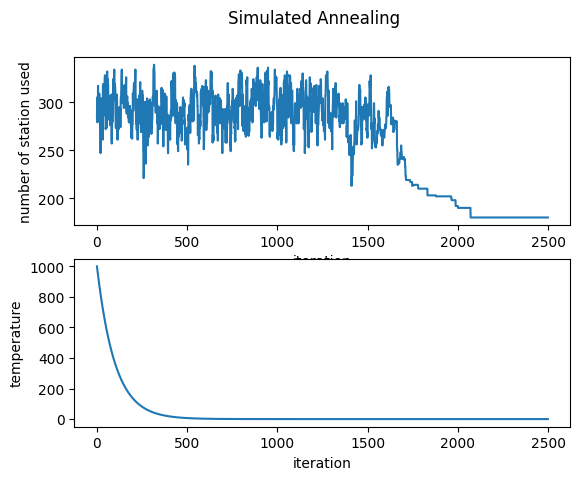

In [5]:
start = stationIDs[0]
end = stationIDs[0]
iteration = 2500
temperature = 1000
coolingRate = 0.01

sa = SimulatedAnnealing(trainNetwork,stationIDs,start,end)
solution,trainErr = sa.Train(iteration,temperature,coolingRate)

# Result of the Simulated Annealing

In [6]:
pd.DataFrame(solution)

,distance,path,remark
0,180,"[PY31, PY03, PY10, KJ8, PY32, PY34, SP21, SP27...",Global Best
1,180,"[PY31, KJ8, PY10, PY03, PY32, PY34, SP21, SP27...",currently proposal
2,187,"[PY31, KJ8, PY10, PY03, PY32, PY34, SP21, SP27...",latest generated


# Best Result

In [7]:
soln = [trainNetwork.vertices.get(stationID) for stationID in solution[0].get("path")]
pd.DataFrame(soln)

,id,stationName,coordinate
0,PY31,Serdang Raya Utara,"{'lat': '3.04168', 'lon': '101.70491'}"
1,PY03,Kampung Selamat,"{'lat': '3.1972781', 'lon': '101.5784398'}"
2,PY10,Kepong Baru,"{'lat': '3.2115497', 'lon': '101.6484978'}"
3,KJ8,Damai,"{'lat': '3.1644056', 'lon': '101.7244889'}"
4,PY32,Serdang Raya Selatan,"{'lat': '3.02854', 'lon': '101.70739'}"
5,PY34,UPM,"{'lat': '3.00850', 'lon': '101.70554'}"
6,SP21,Alam Sutera,"{'lat': '3.0546753', 'lon': '101.6565324'}"
7,SP27,Bandar Puteri,"{'lat': '3.0170271', 'lon': '101.6128574'}"
8,KJ34,USJ 21,"{'lat': '3.0298519', 'lon': '101.5821081'}"
9,KJ13,Masjid Jamek,"{'lat': '3.14940', 'lon': '101.69646'}"


# Map Visualization

In [8]:
stations = solution[0].get("path")
paths = []
for i in range(len(stations)):
    if i > 0:
        from_id = stations[i-1]
        to_id = stations[i]
        travelRes = trainNetwork.breadthFirstSearch(fromID=from_id,toID=to_id)
        if(travelRes.get("err")) : print(travelRes)
        paths.append(travelRes.get("res").get("path"))

# print({"from":stations[0],"to":stations[len(stations)-1]})
allPath = []
for path in paths:
    if len(allPath)>0:path.pop(0)
    allPath+=path

In [9]:
pathData = [trainNetwork.vertices[stationID] for stationID in allPath]
locations = [
    {
        "location":[
            float(path_data.get("coordinate").get("lat")),
            float(path_data.get("coordinate").get("lon"))
        ],
        "popup":path_data.get("stationName")
    }
    for path_data in pathData
]

lat = 0
lon = 0
points = []
for loc in locations:
    lat += loc.get("location")[0]
    lon += loc.get("location")[1]
    points.append(loc.get("location"))
centrold = [lat/len(locations),lon/len(locations)]

Map =  folium.Map(location=centrold, zoom_start = 12)
PolyLine(points,color="red", weight=3.5, opacity=1).add_to(Map)

for loc in locations:
     CircleMarker(
        location=loc.get("location"),
        popup=loc.get("popup"),
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
   ).add_to(Map)
        
for i in range(len(stations)):
    node = trainNetwork.vertices.get(stations[i])
    Marker(
        location=[
            float(node.get("coordinate").get("lat")),
            float(node.get("coordinate").get("lon"))
        ], 
        popup=f'{str(i+1)} - {node.get("stationName")}',
    ).add_to(Map)
    
     
Map